# Part-1: Object Detection - Hatches Open/Close

## Import necessary libraries


In [1]:
import os
import cv2
import json
import glob
import torch
import warnings
import numpy as np
from PIL import Image
from sklearn import svm
import supervision as sv
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
import torchvision.transforms as T
from sklearn.metrics import accuracy_score

## Set the root directory for training data

In [2]:
ROOT_DIR = "cropped/train/"
labels = {}


## Read and label each image in the training directory

In [3]:
for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

## Load the DINOv2 model with ViT-S/14 backbone

In [4]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)

Using cache found in C:\Users\siddh/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Define image transformations

In [5]:
transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

## Define a function to load and transform images into tensors

In [6]:
def load_image(img: str) -> torch.Tensor:
  
    img = Image.open(img)
    transformed_img = transform_image(img)[:3].unsqueeze(0)
    return transformed_img

## Compute embeddings for each file using the DINOv2 model

In [7]:
def compute_embeddings(files: list) -> dict:

    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        print(file)
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

## Compute embeddings

In [8]:
embeddings = compute_embeddings(files)

  0%|          | 0/912 [00:00<?, ?it/s]

cropped/train/bad\m1.jpg
cropped/train/bad\m10.jpg
cropped/train/bad\m10_augmented_1.jpg
cropped/train/bad\m10_augmented_10.jpg
cropped/train/bad\m10_augmented_11.jpg
cropped/train/bad\m10_augmented_12.jpg
cropped/train/bad\m10_augmented_13.jpg
cropped/train/bad\m10_augmented_14.jpg
cropped/train/bad\m10_augmented_15.jpg
cropped/train/bad\m10_augmented_16.jpg
cropped/train/bad\m10_augmented_17.jpg
cropped/train/bad\m10_augmented_18.jpg
cropped/train/bad\m10_augmented_19.jpg
cropped/train/bad\m10_augmented_2.jpg
cropped/train/bad\m10_augmented_20.jpg
cropped/train/bad\m10_augmented_21.jpg
cropped/train/bad\m10_augmented_22.jpg
cropped/train/bad\m10_augmented_23.jpg
cropped/train/bad\m10_augmented_24.jpg
cropped/train/bad\m10_augmented_25.jpg
cropped/train/bad\m10_augmented_26.jpg
cropped/train/bad\m10_augmented_27.jpg
cropped/train/bad\m10_augmented_28.jpg
cropped/train/bad\m10_augmented_29.jpg
cropped/train/bad\m10_augmented_3.jpg
cropped/train/bad\m10_augmented_30.jpg
cropped/train/ba

## Train an SVM classifier on the embeddings

In [9]:
clf = svm.SVC(gamma='scale')
y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

clf = svm.SVC(gamma='scale')
clf.fit(np.array(embedding_list).reshape(-1, 384), y) 

SVC()

In [10]:
# !pip install scikit-learn

In [11]:
# !pip install supervision

## Test image-1

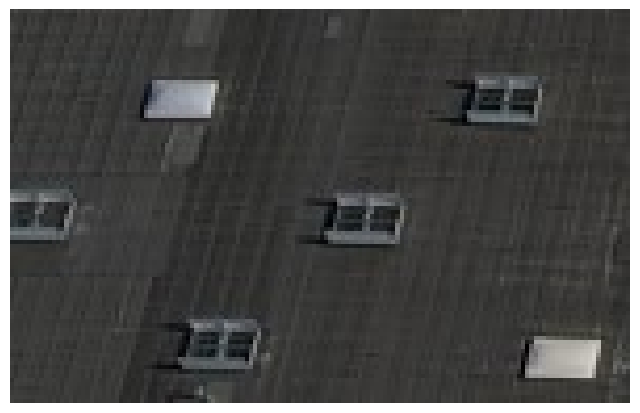


Predicted class: bad


In [12]:
input_file = "C:/Users/siddh/Desktop/innovation challenge 2024/cropped/bad/m13.jpg"

new_image = load_image(input_file)

%matplotlib inline
sv.plot_image(image=cv2.imread(input_file), size=(8, 8))

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print()
    print("Predicted class: " + prediction[0])

## Test image-2

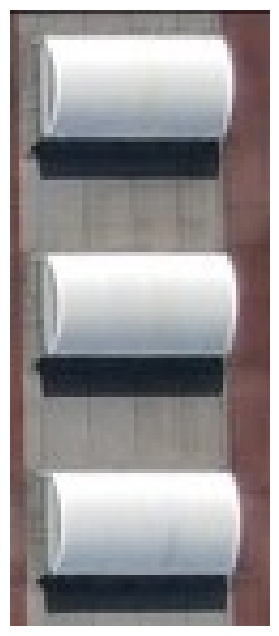


Predicted class: good


In [13]:
input_file = "C:/Users/siddh/Desktop/innovation challenge 2024/cropped/good/v17_augmented_26.jpg"

new_image = load_image(input_file)

%matplotlib inline
sv.plot_image(image=cv2.imread(input_file), size=(8, 8))

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print()
    print("Predicted class: " + prediction[0])

In [14]:
# def load_test_images(test_dir):
#     files = []
#     labels = {}
#     for folder in os.listdir(test_dir):
#         folder_path = os.path.join(test_dir, folder)
#         for file in os.listdir(folder_path):
#             if file.endswith(".jpg"):
#                 full_name = os.path.join(folder_path, file)
#                 files.append(full_name)
#                 labels[full_name] = folder  # Assuming folder names are 'good', 'bad', etc.
#     return files, labels

# def get_embeddings(files):
#     embeddings = {}
#     with torch.no_grad():
#         for file in tqdm(files):
#             embeddings[file] = np.array(dinov2_vits14(load_image(file).to(device))).reshape(1, -1).tolist()
#     return embeddings

# transform_image = T.Compose([
#     T.ToTensor(),
#     T.Resize(244),
#     T.CenterCrop(224),
#     T.Normalize([0.5], [0.5])
# ])

# def load_image(img: str) -> torch.Tensor:
#     img = Image.open(img)
#     transformed_img = transform_image(img)[:3].unsqueeze(0)
#     return transformed_img

## Directory containing the test images


In [15]:
test_dir = "C:/Users/siddh/Desktop/innovation challenge 2024/cropped/test/"

## List all JPEG files in the test directory for processing

In [16]:
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]

## Function to predict the class of an image using the specified model and SVM classifier

In [17]:
def predict_class(file_path, model, svm_classifier):
    image_tensor = load_image(file_path)
    with torch.no_grad():
        embedding = model(image_tensor.to(device))
    # Reshape the embedding to match the input expected by the SVM
    embedding_np = np.array(embedding.cpu()).reshape(1, -1)
    return svm_classifier.predict(embedding_np)[0]


## Dictionary to hold true labels for test images, useful for evaluation


In [18]:
true_labels = {
    os.path.join(test_dir, f): 'label'  # You need to fill in the actual label here
    for f in os.listdir(test_dir) if f.endswith('.jpg')
}

# Dictionary to store predicted labels for each file
predicted_labels = {file: predict_class(file, dinov2_vits14, clf) for file in test_files}

## Function to determine the label of an image based on the first letter of its filename


In [19]:

def determine_label(filename):
    first_letter = os.path.basename(filename)[0].lower()  # Ensure case insensitivity
    if first_letter == 'm':
        return 'bad'
    elif first_letter == 'v':
        return 'good'
    else:
        return 'unknown'  # Adjust or handle unknown cases if needed


## Generate a list of test file paths in the specified directory


In [20]:
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]
print("Number of test files:", len(test_files))  # Check the actual number of files processed


Number of test files: 40


## Dictionary to store the predicted labels for each test file using a trained model and SVM classifier


In [21]:
predicted_labels = {file: predict_class(file, dinov2_vits14, clf) for file in test_files}
print("Predictions made:", len(predicted_labels))  # Should match the number of test files


Predictions made: 40


In [22]:
# Determine the true labels for the test files using the determine_label function
y_true = [determine_label(file) for file in test_files]

# Retrieve the predicted labels for comparison
y_pred = [predicted_labels[file] for file in test_files]

# Identify indices where the true label is not 'unknown' to exclude them from accuracy calculation
filtered_indices = [i for i, label in enumerate(y_true) if label != 'unknown']

# Filter the true and predicted labels arrays based on the identified indices
y_true_filtered = [y_true[i] for i in filtered_indices]
y_pred_filtered = [y_pred[i] for i in filtered_indices]

# Calculate and print the model's accuracy only if there are valid labels to compare
if len(y_true_filtered) > 0 and len(y_pred_filtered) > 0:
    accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
    print(f"Accuracy of the model on the test set: {accuracy * 100:.2f}%")
else:
    print("No valid labels to calculate accuracy.")


Accuracy of the model on the test set: 97.50%


# Part-2: Object Detection - Construction Objects

In [23]:
# Define the root directory where the training images are stored
ROOT_DIR = "croppedd_constr/train/"

# Initialize a dictionary to store labels for each image
labels = {}

# Loop through each folder in the root directory
for folder in os.listdir(ROOT_DIR):
    # Loop through each file within the folder
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        # Check if the file is a JPEG image
        if file.endswith(".jpg"):
            # Construct the full path of the file
            full_name = os.path.join(ROOT_DIR, folder, file)
            # Map the file path to its folder name, which is used as a label
            labels[full_name] = folder


# Retrieve all the file paths from the labels dictionary
files = labels.keys()

## Compute embeddings

In [24]:
embeddings = compute_embeddings(files)

  0%|          | 0/598 [00:00<?, ?it/s]

croppedd_constr/train/bad\cropped_3_augmented_1.jpg
croppedd_constr/train/bad\cropped_3_augmented_10.jpg
croppedd_constr/train/bad\cropped_3_augmented_11.jpg
croppedd_constr/train/bad\cropped_3_augmented_12.jpg
croppedd_constr/train/bad\cropped_3_augmented_13.jpg
croppedd_constr/train/bad\cropped_3_augmented_14.jpg
croppedd_constr/train/bad\cropped_3_augmented_15.jpg
croppedd_constr/train/bad\cropped_3_augmented_16.jpg
croppedd_constr/train/bad\cropped_3_augmented_17.jpg
croppedd_constr/train/bad\cropped_3_augmented_18.jpg
croppedd_constr/train/bad\cropped_3_augmented_19.jpg
croppedd_constr/train/bad\cropped_3_augmented_2.jpg
croppedd_constr/train/bad\cropped_3_augmented_20.jpg
croppedd_constr/train/bad\cropped_3_augmented_21.jpg
croppedd_constr/train/bad\cropped_3_augmented_22.jpg
croppedd_constr/train/bad\cropped_3_augmented_23.jpg
croppedd_constr/train/bad\cropped_3_augmented_24.jpg
croppedd_constr/train/bad\cropped_3_augmented_25.jpg
croppedd_constr/train/bad\cropped_3_augmented_26

## Train an SVM classifier on the embeddings

In [26]:
clf = svm.SVC(gamma='scale')

y = [labels[file] for file in files]
embedding_list = list(embeddings.values())

clf = svm.SVC(gamma='scale')
clf.fit(np.array(embedding_list).reshape(-1, 384), y) 

SVC()

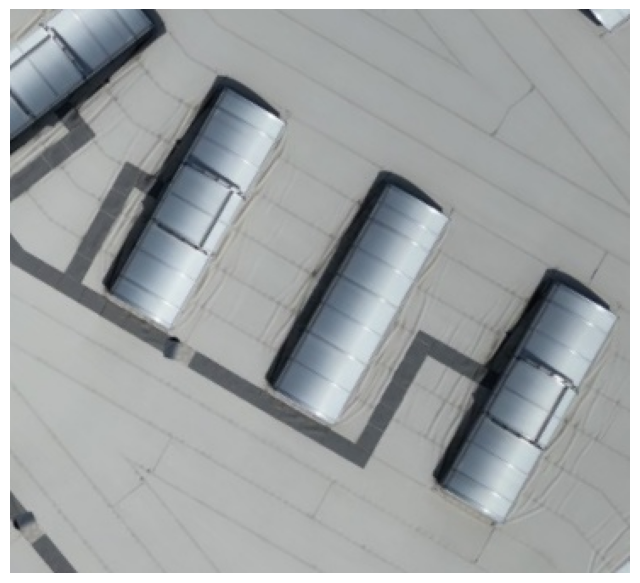


Predicted class: good


In [36]:
# Load an image for prediction
input_file = "C:/Users/siddh/Desktop/innovation challenge 2024/croppedd_constr/test\v4_augmented_21.jpg"
new_image = load_image(input_file)

# Display the image using OpenCV and Supervision library
%matplotlib inline
sv.plot_image(image=cv2.imread(input_file), size=(8, 8))

# Disable gradient calculations for performance
with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))
    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print()
    print("Predicted class: " + prediction[0])

## Directory containing test images

In [39]:
test_dir = "C:/Users/siddh/Desktop/innovation challenge 2024/croppedd_constr/test/"


## List all JPEG files in the test directory for processing


In [40]:
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]


In [43]:
true_labels = {
    os.path.join(test_dir, f): 'label'  # You need to fill in the actual label here
    for f in os.listdir(test_dir) if f.endswith('.jpg')
}


In [42]:
predicted_labels = {file: predict_class(file, dinov2_vits14, clf) for file in test_files}


## Generate a list of test file paths in the specified directory


In [44]:
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]
print("Number of test files:", len(test_files))  # Check the actual number of files processed


Number of test files: 43


## Dictionary to store the predicted labels for each test file using a trained model and SVM classifier


In [45]:
predicted_labels = {file: predict_class(file, dinov2_vits14, clf) for file in test_files}
print("Predictions made:", len(predicted_labels))  # Should match the number of test files


Predictions made: 43


In [46]:
y_true = [determine_label(file) for file in test_files]
y_pred = [predicted_labels[file] for file in test_files]

# Filter out 'unknown' labels if they should not contribute to accuracy calculation
filtered_indices = [i for i, label in enumerate(y_true) if label != 'unknown']
y_true_filtered = [y_true[i] for i in filtered_indices]
y_pred_filtered = [y_pred[i] for i in filtered_indices]

# Calculate accuracy only if there are valid labels
if len(y_true_filtered) > 0 and len(y_pred_filtered) > 0:
    accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
    print(f"Accuracy of the model on the test set: {accuracy * 100:.2f}%")
else:
    print("No valid labels to calculate accuracy.")


Accuracy of the model on the test set: 83.72%
